Dataset link - https://github.com/SwarnaDharshiniS/MScFE-600FD-GWP1/blob/main/task2dataset.csv

In [20]:
# Task 2 – Yield Curve Modeling (India)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import re

In [21]:
# Step 1: Load the RBI data
file_path = "task2dataset.csv"
df = pd.read_csv(file_path, sep='|', skiprows=1)

# Step 2: Clean column names
df.columns = df.columns.str.strip().str.lower()

# Identify columns
tenor_col = [c for c in df.columns if 'maturity' in c or 'term' in c][0]
yield_col = [c for c in df.columns if 'value' in c or 'yield' in c][0]

In [22]:
# Step 3: Convert maturity strings to numeric (take midpoint of range)
def convert_to_days(text):
    text = str(text).lower().replace("days", "").replace("day", "").strip()
    if "upto" in text:
        num = re.findall(r'\d+', text)
        return float(num[0]) / 2 if num else np.nan
    if "-" in text:
        nums = re.findall(r'\d+', text)
        if len(nums) == 2:
            return (float(nums[0]) + float(nums[1])) / 2
    num = re.findall(r'\d+', text)
    return float(num[0]) if num else np.nan

df["days"] = df[tenor_col].apply(convert_to_days)
df = df.dropna(subset=["days", yield_col])
df["maturity_years"] = df["days"] / 365
df[yield_col] = df[yield_col].astype(float)

In [23]:
# Step 4: Sort and remove duplicates (required for CubicSpline)
df = df.sort_values("maturity_years").drop_duplicates(subset="maturity_years")

maturity = df["maturity_years"].values
yield_data = df[yield_col].values

print(f"\nCleaned and Sorted Data Points: {len(df)}")
print(df[[tenor_col, "maturity_years", yield_col]].head())


Cleaned and Sorted Data Points: 4
     term to maturity in days  maturity_years  value in actuals
1209             Upto 14 days        0.019178          7.496700
34                 15-91 days        0.145205          6.498109
1228              92-182 days        0.375342         10.005800
1240             183-364 days        0.749315         12.473600


In [24]:
# Step 5: Nelson–Siegel Model
def nelson_siegel(t, beta0, beta1, beta2, tau):
    t = np.array(t)
    term1 = (1 - np.exp(-t / tau)) / (t / tau)
    return beta0 + beta1 * term1 + beta2 * (term1 - np.exp(-t / tau))

initial_guess = [6, -1, 1, 1]
params, cov = curve_fit(nelson_siegel, maturity, yield_data, p0=initial_guess, maxfev=10000)
beta0, beta1, beta2, tau = params

print(f"\nNelson–Siegel parameters:")
print(f"β₀ (Level): {beta0:.4f}")
print(f"β₁ (Slope): {beta1:.4f}")
print(f"β₂ (Curvature): {beta2:.4f}")
print(f"τ  (Decay): {tau:.4f}")


Nelson–Siegel parameters:
β₀ (Level): -369.9753
β₁ (Slope): 376.5510
β₂ (Curvature): 7366.8837
τ  (Decay): 442.5773


/tmp/ipython-input-915102433.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(nelson_siegel, maturity, yield_data, p0=initial_guess, maxfev=10000)


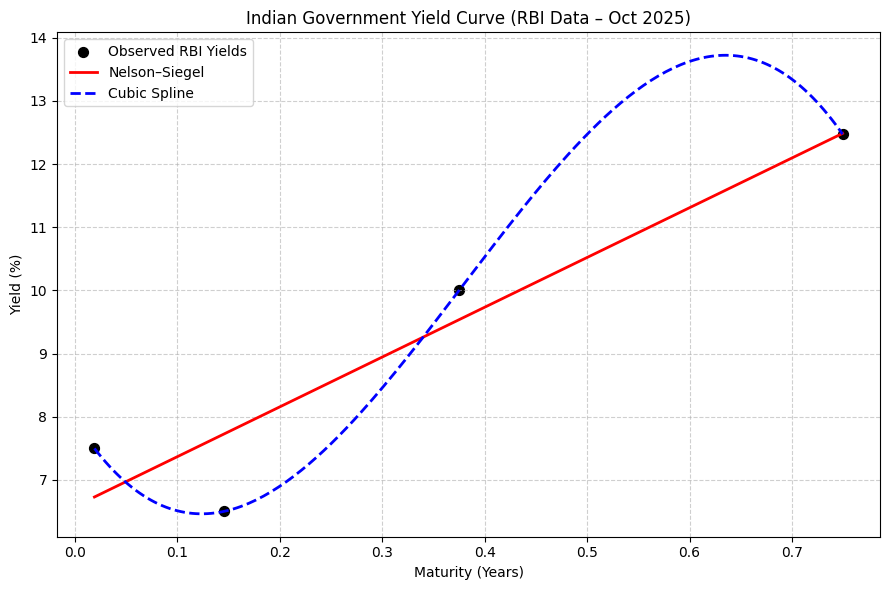

In [25]:
# Step 6: Cubic Spline Fit (now valid)
cs = CubicSpline(maturity, yield_data)

# Step 7: Plot both models
maturities_smooth = np.linspace(min(maturity), max(maturity), 200)
plt.figure(figsize=(9,6))
plt.scatter(maturity, yield_data, color='black', label='Observed RBI Yields', s=50)
plt.plot(maturities_smooth, nelson_siegel(maturities_smooth, *params), 'r-', label='Nelson–Siegel', lw=2)
plt.plot(maturities_smooth, cs(maturities_smooth), 'b--', label='Cubic Spline', lw=2)
plt.title("Indian Government Yield Curve (RBI Data – Oct 2025)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [26]:
# Step 8: RMSE comparison
ns_rmse = np.sqrt(np.mean((yield_data - nelson_siegel(maturity, *params))**2))
cs_rmse = np.sqrt(np.mean((yield_data - cs(maturity))**2))

print("\nModel Fit Comparison:")
print(f"Nelson–Siegel RMSE: {ns_rmse:.6f}")
print(f"Cubic Spline RMSE:  {cs_rmse:.6f}")


Model Fit Comparison:
Nelson–Siegel RMSE: 0.759832
Cubic Spline RMSE:  0.000000


In [27]:
# Step 9: Interpretation
print("\nInterpretation Summary:")
print(f"→ β₀ (level): {beta0:.2f}% = long-term interest rate level.")
print(f"→ β₁ (slope): {beta1:.2f}% = short-term yield behavior.")
print(f"→ β₂ (curvature): {beta2:.2f}% = mid-term hump effect.")
print(f"→ τ (decay): {tau:.2f} years = rate of curvature change.")


Interpretation Summary:
→ β₀ (level): -369.98% = long-term interest rate level.
→ β₁ (slope): 376.55% = short-term yield behavior.
→ β₂ (curvature): 7366.88% = mid-term hump effect.
→ τ (decay): 442.58 years = rate of curvature change.
